# 0.사전 준비

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

base_gdrive_path = os.path.join('drive', 'MyDrive', 'deepLearningProject')

In [ ]:
from pathlib import Path
import os

result_path = os.path.join(base_gdrive_path, "results")
Path(result_path).mkdir(parents=True, exist_ok=True)

# 1.데이터셋(로보플로에서 받음)

In [ ]:
!curl -L "https://public.roboflow.com/ds/6qOjE2oi5X?key=YMVrflOddR" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# Base libraries
import os
import random

# Keras libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, Softmax
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.8.2


In [ ]:
from PIL import Image
import os, glob

In [ ]:
def resize_images(img_path):
    
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")

def load_data(img_path, number_of_data=2520):  # 가위바위보 이미지 개수 총합에 주의
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissors/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1

    return imgs, labels

## 1) 트레인 데이터셋

In [ ]:
scissor_image_dir_path = "/content/train/scissors"
rock_image_dir_path = "/content/train/rock"
paper_image_dir_path = "/content/train/paper"
resize_images(scissor_image_dir_path)
resize_images(rock_image_dir_path)
resize_images(paper_image_dir_path)

image_dir_path = "/content/train"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

840  images to be resized.
840  images resized.
840  images to be resized.
840  images resized.
840  images to be resized.
840  images resized.
x_train shape: (2520, 28, 28, 3)
y_train shape: (2520,)


## 2) 유효 데이터셋

In [ ]:
scissor_valid_dir_path="/content/valid/scissors"
rock_valid_dir_path="/content/valid/rock"
paper_valid_dir_path="/content/valid/paper"
resize_images(scissor_valid_dir_path)
resize_images(rock_valid_dir_path)
resize_images(paper_valid_dir_path)

valid_dir_path="/content/valid"
(x_valid,y_valid)=load_data(valid_dir_path,372)
x_valid_norm=x_valid/255.0

print(f"x_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

124  images to be resized.
124  images resized.
124  images to be resized.
124  images resized.
124  images to be resized.
124  images resized.
x_valid shape: (372, 28, 28, 3)
y_valid shape: (372,)


## 3) 테스트 데이터셋

In [ ]:
scissor_test_dir_path="/content/test/scissors"
rock_test_dir_path="/content/test/rock"
paper_test_dir_path="/content/test/paper"
resize_images(scissor_test_dir_path)
resize_images(rock_test_dir_path)
resize_images(paper_test_dir_path)

test_dir_path="/content/test"
(x_test,y_test)=load_data(test_dir_path,33)
x_test_norm=x_test/255.0

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

11  images to be resized.
11  images resized.
11  images to be resized.
11  images resized.
11  images to be resized.
11  images resized.
x_test shape: (33, 28, 28, 3)
y_test shape: (33,)


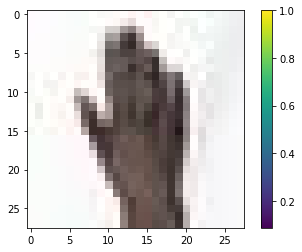

0


In [ ]:
plt.figure()
plt.imshow(x_train_norm[2000])
plt.colorbar()
plt.grid(False)
plt.show()
print(y_train[0])

# 2.모델1(dense)

In [ ]:
def model_1(input_shape=(28, 28,3)):
  input = keras.layers.Input((28, 28,3))
  flatten = keras.layers.Flatten()(input)
  dense_1 = keras.layers.Dense(1000, activation='relu')(flatten)
  dense_2 = keras.layers.Dense(500, activation='relu')(dense_1)
  dense_3 = keras.layers.Dense(50, activation='relu')(dense_2)
  dense_4 = keras.layers.Dense(3, activation='softmax')(dense_3)

  return keras.models.Model(inputs=[input], outputs=[dense_4])

## 1) 모델 Summary

In [ ]:
model_1 = model_1()
model_1.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 28, 28, 3)]       0         
                                                                 
 flatten_11 (Flatten)        (None, 2352)              0         
                                                                 
 dense_33 (Dense)            (None, 1000)              2353000   
                                                                 
 dense_34 (Dense)            (None, 500)               500500    
                                                                 
 dense_35 (Dense)            (None, 50)                25050     
                                                                 
 dense_36 (Dense)            (None, 3)                 153       
                                                                 
Total params: 2,878,703
Trainable params: 2,878,703
Non-tr

In [ ]:
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

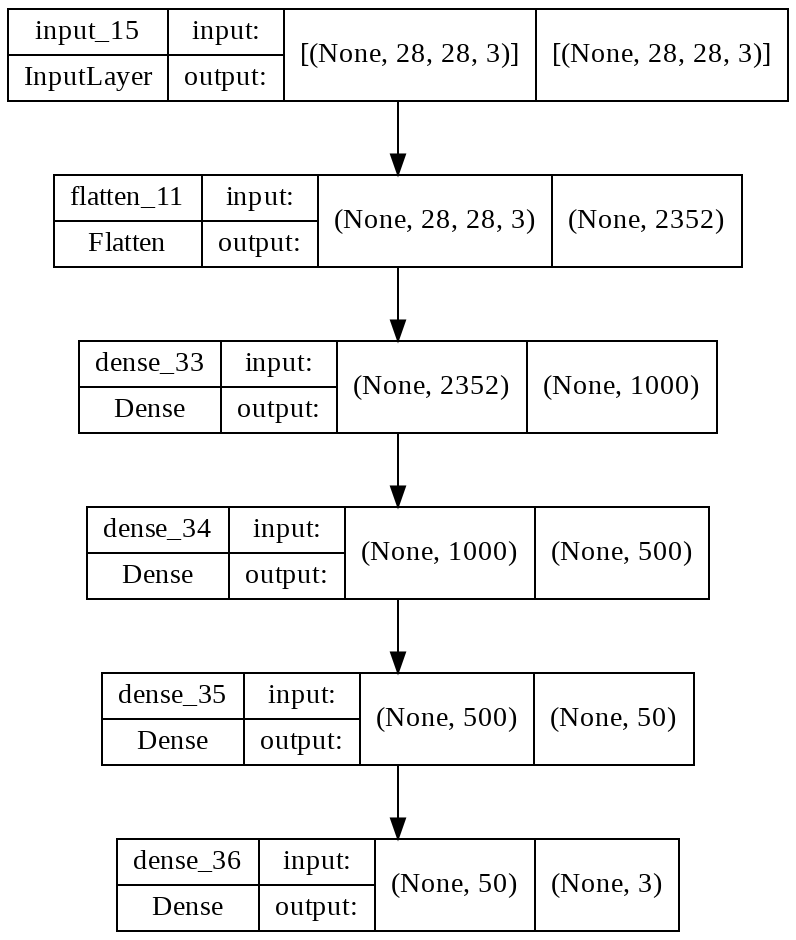

In [ ]:
from tensorflow.keras.utils import plot_model
MODEL_NAME="denseModel"
filename = os.path.join(result_path, f'{MODEL_NAME}.png')
plot_model(model_1, show_shapes=True, to_file=filename, expand_nested=True, dpi=144)

## 2) 모델 트레이닝

In [ ]:
BATCH_SIZE = 32
num_train_examples = len(x_train_norm)

import math

history_1 = model_1.fit(x_train_norm, y_train, epochs=10, batch_size=BATCH_SIZE, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE),validation_data=(x_valid_norm,y_valid))

Epoch 1/10
79/79 [==============================] - 3s 28ms/step - loss: 1.1396 - accuracy: 0.4734 - val_loss: 1.1125 - val_accuracy: 0.3871
Epoch 2/10
79/79 [==============================] - 2s 25ms/step - loss: 0.7722 - accuracy: 0.6607 - val_loss: 0.9804 - val_accuracy: 0.5591
Epoch 3/10
79/79 [==============================] - 2s 24ms/step - loss: 0.5324 - accuracy: 0.8024 - val_loss: 1.1506 - val_accuracy: 0.5161
Epoch 4/10
79/79 [==============================] - 2s 24ms/step - loss: 0.3753 - accuracy: 0.8607 - val_loss: 1.4716 - val_accuracy: 0.4919
Epoch 5/10
79/79 [==============================] - 2s 24ms/step - loss: 0.2549 - accuracy: 0.9111 - val_loss: 1.4831 - val_accuracy: 0.5538
Epoch 6/10
79/79 [==============================] - 2s 24ms/step - loss: 0.2894 - accuracy: 0.8889 - val_loss: 2.0258 - val_accuracy: 0.5591
Epoch 7/10
79/79 [==============================] - 2s 24ms/step - loss: 0.1921 - accuracy: 0.9393 - val_loss: 1.8937 - val_accuracy: 0.5565
Epoch 8/10
79

## 3) 트레이닝 진행 결과

### 정확도

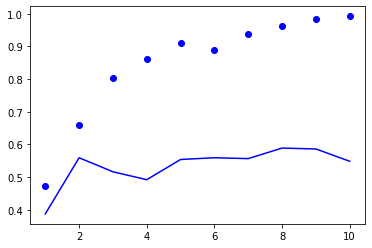

In [ ]:
history_1_accuracy = history_1.history["accuracy"]
history_1_val_accuracy = history_1.history["val_accuracy"]

epochs = range(1, len(history_1_accuracy) + 1)
plt.plot(epochs, history_1_accuracy, "bo", label="Training accuracy")
plt.plot(epochs, history_1_val_accuracy, "b", label="Validation accuracy")


### 로스

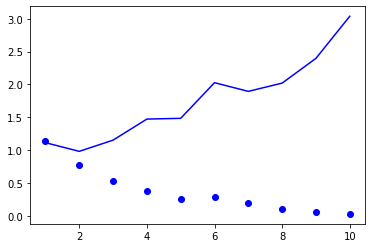

In [ ]:
history_1_loss = history_1.history["loss"]
history_1_val_loss = history_1.history["val_loss"]

epochs = range(1, len(history_1_loss) + 1)
plt.plot(epochs, history_1_loss, "bo", label="Training loss")
plt.plot(epochs, history_1_val_loss, "b", label="Validation loss")


# 3.모델2(conv)

In [ ]:
def cnn_classification_model():
  input = keras.layers.Input((28, 28, 3))

  conv_1 = keras.layers.Conv2D(6, 3, activation='relu', padding='same')(input)
  conv_1 = keras.layers.Conv2D(6, 3, activation='relu', padding='same')(conv_1)
  pool_1 = keras.layers.MaxPooling2D((2, 2), strides=2)(conv_1)

  conv_3 = keras.layers.Conv2D(16, 3, activation='relu', padding='same')(pool_1)
  conv_3 = keras.layers.Conv2D(16, 3, activation='relu', padding='same')(conv_3)
  pool_2 = keras.layers.MaxPooling2D((2, 2), strides=2)(conv_3)

  flatten = keras.layers.Flatten()(pool_2)
  dense_1 = keras.layers.Dense(120)(flatten)
  dense_2 = keras.layers.Dense(84)(dense_1)
  dense_3 = keras.layers.Dense(3, activation='softmax')(dense_2)

  return keras.models.Model(inputs=[input], outputs=[dense_3])

## 1) 모델 Summary

In [ ]:
model_2 = cnn_classification_model()
model_2.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_120 (Conv2D)         (None, 28, 28, 6)         168       
                                                                 
 conv2d_121 (Conv2D)         (None, 28, 28, 6)         330       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_122 (Conv2D)         (None, 14, 14, 16)        880       
                                                                 
 conv2d_123 (Conv2D)         (None, 14, 14, 16)        2320      
                                                          

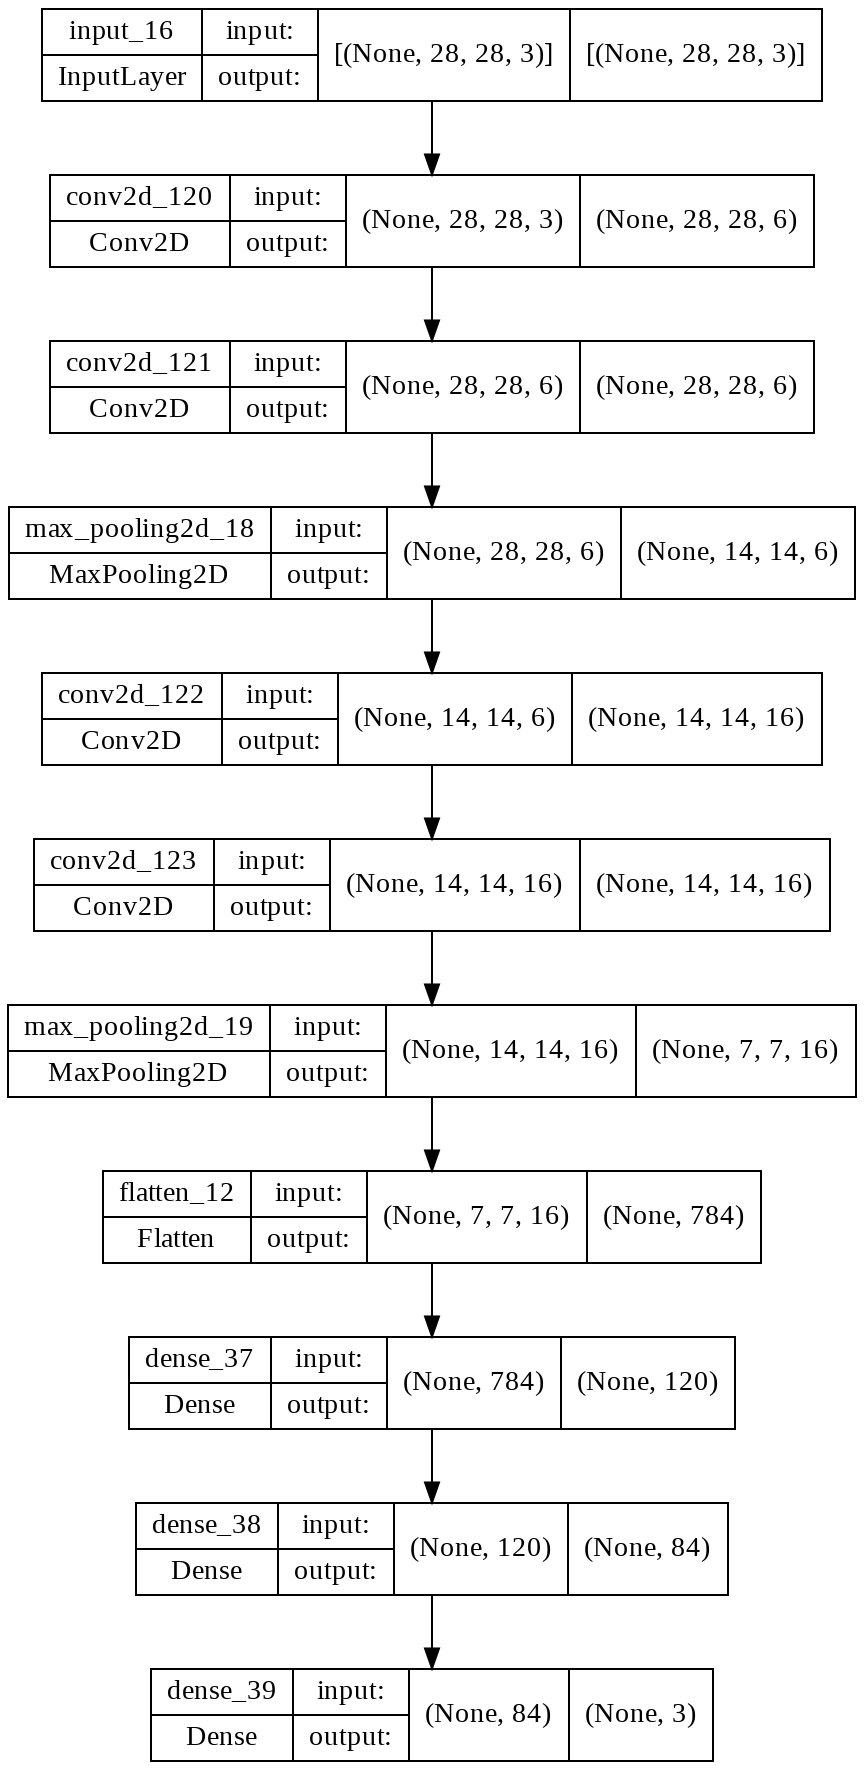

In [ ]:
MODEL_NAME="convModel"
filename = os.path.join(result_path, f'{MODEL_NAME}.png')
plot_model(model_2, show_shapes=True, to_file=filename, expand_nested=True, dpi=144)

In [ ]:
model_2.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## 2) 모델 트레이닝

In [ ]:
BATCH_SIZE = 32
num_train_examples = len(x_train_norm)

import math

history_2 = model_2.fit(x_train_norm, y_train, epochs=10, batch_size=BATCH_SIZE, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE),validation_data=(x_valid_norm,y_valid))

Epoch 1/10
79/79 [==============================] - 4s 43ms/step - loss: 0.7350 - accuracy: 0.6659 - val_loss: 0.5550 - val_accuracy: 0.7661
Epoch 2/10
79/79 [==============================] - 3s 40ms/step - loss: 0.0929 - accuracy: 0.9746 - val_loss: 0.4250 - val_accuracy: 0.8683
Epoch 3/10
79/79 [==============================] - 3s 40ms/step - loss: 0.0110 - accuracy: 0.9984 - val_loss: 0.6580 - val_accuracy: 0.8414
Epoch 4/10
79/79 [==============================] - 3s 40ms/step - loss: 0.0053 - accuracy: 0.9992 - val_loss: 0.7753 - val_accuracy: 0.8360
Epoch 5/10
79/79 [==============================] - 3s 40ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.8428 - val_accuracy: 0.8360
Epoch 6/10
79/79 [==============================] - 3s 40ms/step - loss: 6.8009e-04 - accuracy: 1.0000 - val_loss: 0.8435 - val_accuracy: 0.8468
Epoch 7/10
79/79 [==============================] - 3s 41ms/step - loss: 3.8622e-04 - accuracy: 1.0000 - val_loss: 0.8868 - val_accuracy: 0.8495
Epoch

## 3) 트레이닝 진행 결과

### 정확도

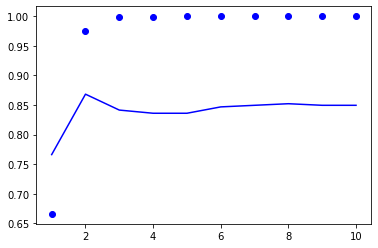

In [ ]:
history_2_accuracy = history_2.history["accuracy"]
history_2_val_accuracy = history_2.history["val_accuracy"]

epochs = range(1, len(history_2_accuracy) + 1)
plt.plot(epochs, history_2_accuracy, "bo", label="Training accuracy")
plt.plot(epochs, history_2_val_accuracy, "b", label="Validation accuracy")


### 로스

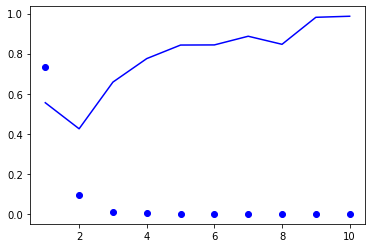

In [ ]:
history_2_loss = history_2.history["loss"]
history_2_val_loss = history_2.history["val_loss"]

epochs = range(1, len(history_2_loss) + 1)
plt.plot(epochs, history_2_loss, "bo", label="Training loss")
plt.plot(epochs, history_2_val_loss, "b", label="Validation loss")


# 4.모델3(resnet_34)

In [ ]:
def resnet_34(input_shape = (28, 28, 3)):
    base_channel_num = 32  # 64 in paper

    input = keras.layers.Input(input_shape)

    conv_1 = keras.layers.Conv2D(filters=base_channel_num, kernel_size=7, strides=2, padding='same', activation='relu')(input)

    conv_2 = keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(conv_1)

    conv_2_residual = conv_2
    conv_2 = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, padding='same', activation='relu')(conv_2)
    conv_2 = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, padding='same', activation='relu')(conv_2)
    conv_2 = keras.layers.Add()([conv_2, conv_2_residual])  # 1
    conv_2_residual = conv_2
    conv_2 = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, padding='same', activation='relu')(conv_2)
    conv_2 = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, padding='same', activation='relu')(conv_2)
    conv_2 = keras.layers.Add()([conv_2, conv_2_residual])  # 2
    conv_2_residual = conv_2
    conv_2 = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, padding='same', activation='relu')(conv_2)
    conv_2 = keras.layers.Conv2D(filters=base_channel_num, kernel_size=3, padding='same', activation='relu')(conv_2)
    conv_2 = keras.layers.Add()([conv_2, conv_2_residual])  # 3

    conv_3_residual = conv_2
    conv_3_residual = keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(conv_3_residual)
    conv_3_residual = keras.layers.Conv2D(filters=base_channel_num*2, kernel_size=1, padding='same', activation='relu')(conv_3_residual)
    conv_3 = keras.layers.Conv2D(filters=base_channel_num*2, kernel_size=3, strides=2, padding='same', activation='relu')(conv_2)
    conv_3 = keras.layers.Conv2D(filters=base_channel_num*2, kernel_size=3, padding='same', activation='relu')(conv_3)
    conv_3 = keras.layers.Add()([conv_3, conv_3_residual])  # 1
    conv_3_residual = conv_3
    conv_3 = keras.layers.Conv2D(filters=base_channel_num*2, kernel_size=3, padding='same', activation='relu')(conv_3)
    conv_3 = keras.layers.Conv2D(filters=base_channel_num*2, kernel_size=3, padding='same', activation='relu')(conv_3)
    conv_3 = keras.layers.Add()([conv_3, conv_3_residual])  # 2
    conv_3_residual = conv_3
    conv_3 = keras.layers.Conv2D(filters=base_channel_num*2, kernel_size=3, padding='same', activation='relu')(conv_3)
    conv_3 = keras.layers.Conv2D(filters=base_channel_num*2, kernel_size=3, padding='same', activation='relu')(conv_3)
    conv_3 = keras.layers.Add()([conv_3, conv_3_residual])  # 3
    conv_3_residual = conv_3
    conv_3 = keras.layers.Conv2D(filters=base_channel_num*2, kernel_size=3, padding='same', activation='relu')(conv_3)
    conv_3 = keras.layers.Conv2D(filters=base_channel_num*2, kernel_size=3, padding='same', activation='relu')(conv_3)
    conv_3 = keras.layers.Add()([conv_3, conv_3_residual])  # 4

    conv_4_residual = conv_3
    conv_4_residual = keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(conv_4_residual)
    conv_4_residual = keras.layers.Conv2D(filters=base_channel_num*4, kernel_size=1, padding='same', activation='relu')(conv_4_residual)
    conv_4 = keras.layers.Conv2D(filters=base_channel_num*4, kernel_size=3, strides=2, padding='same', activation='relu')(conv_3)
    conv_4 = keras.layers.Conv2D(filters=base_channel_num*4, kernel_size=3, padding='same', activation='relu')(conv_4)
    conv_4 = keras.layers.Add()([conv_4, conv_4_residual])  # 1
    conv_4_residual = conv_4
    conv_4 = keras.layers.Conv2D(filters=base_channel_num*4, kernel_size=3, padding='same', activation='relu')(conv_4)
    conv_4 = keras.layers.Conv2D(filters=base_channel_num*4, kernel_size=3, padding='same', activation='relu')(conv_4)
    conv_4 = keras.layers.Add()([conv_4, conv_4_residual])  # 2
    conv_4_residual = conv_4
    conv_4 = keras.layers.Conv2D(filters=base_channel_num*4, kernel_size=3, padding='same', activation='relu')(conv_4)
    conv_4 = keras.layers.Conv2D(filters=base_channel_num*4, kernel_size=3, padding='same', activation='relu')(conv_4)
    conv_4 = keras.layers.Add()([conv_4, conv_4_residual])  # 3
    conv_4_residual = conv_4
    conv_4 = keras.layers.Conv2D(filters=base_channel_num*4, kernel_size=3, padding='same', activation='relu')(conv_4)
    conv_4 = keras.layers.Conv2D(filters=base_channel_num*4, kernel_size=3, padding='same', activation='relu')(conv_4)
    conv_4 = keras.layers.Add()([conv_4, conv_4_residual])  # 4
    conv_4_residual = conv_4
    conv_4 = keras.layers.Conv2D(filters=base_channel_num*4, kernel_size=3, padding='same', activation='relu')(conv_4)
    conv_4 = keras.layers.Conv2D(filters=base_channel_num*4, kernel_size=3, padding='same', activation='relu')(conv_4)
    conv_4 = keras.layers.Add()([conv_4, conv_4_residual])  # 5
    conv_4_residual = conv_4
    conv_4 = keras.layers.Conv2D(filters=base_channel_num*4, kernel_size=3, padding='same', activation='relu')(conv_4)
    conv_4 = keras.layers.Conv2D(filters=base_channel_num*4, kernel_size=3, padding='same', activation='relu')(conv_4)
    conv_4 = keras.layers.Add()([conv_4, conv_4_residual])  # 6
    
    conv_5_residual = conv_4
    conv_5_residual = keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(conv_5_residual)
    conv_5_residual = keras.layers.Conv2D(filters=base_channel_num*8, kernel_size=1, padding='same', activation='relu')(conv_5_residual)
    conv_5 = keras.layers.Conv2D(filters=base_channel_num*8, kernel_size=3, strides=2, padding='same', activation='relu')(conv_4)
    conv_5 = keras.layers.Conv2D(filters=base_channel_num*8, kernel_size=3, padding='same', activation='relu')(conv_5)
    conv_5 = keras.layers.Add()([conv_5, conv_5_residual])  # 1
    conv_5_residual = conv_5
    conv_5 = keras.layers.Conv2D(filters=base_channel_num*8, kernel_size=3, padding='same', activation='relu')(conv_5)
    conv_5 = keras.layers.Conv2D(filters=base_channel_num*8, kernel_size=3, padding='same', activation='relu')(conv_5)
    conv_5 = keras.layers.Add()([conv_5, conv_5_residual])  # 2
    conv_5_residual = conv_5
    conv_5 = keras.layers.Conv2D(filters=base_channel_num*8, kernel_size=3, padding='same', activation='relu')(conv_5)
    conv_5 = keras.layers.Conv2D(filters=base_channel_num*8, kernel_size=3, padding='same', activation='relu')(conv_5)
    conv_5 = keras.layers.Add()([conv_5, conv_5_residual])  # 3

    ap = keras.layers.GlobalAveragePooling2D()(conv_5)
    dense_1 = keras.layers.Dense(3, activation='softmax')(ap)
    
    
    return keras.models.Model(inputs=[input], outputs=[dense_1])


## 1) 모델 Summary

In [ ]:
model_3 = resnet_34()
model_3.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d_124 (Conv2D)            (None, 14, 14, 32)   4736        ['input_17[0][0]']               
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, 7, 7, 32)    0           ['conv2d_124[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_125 (Conv2D)            (None, 7, 7, 32)     9248        ['max_pooling2d_20[0][0]']

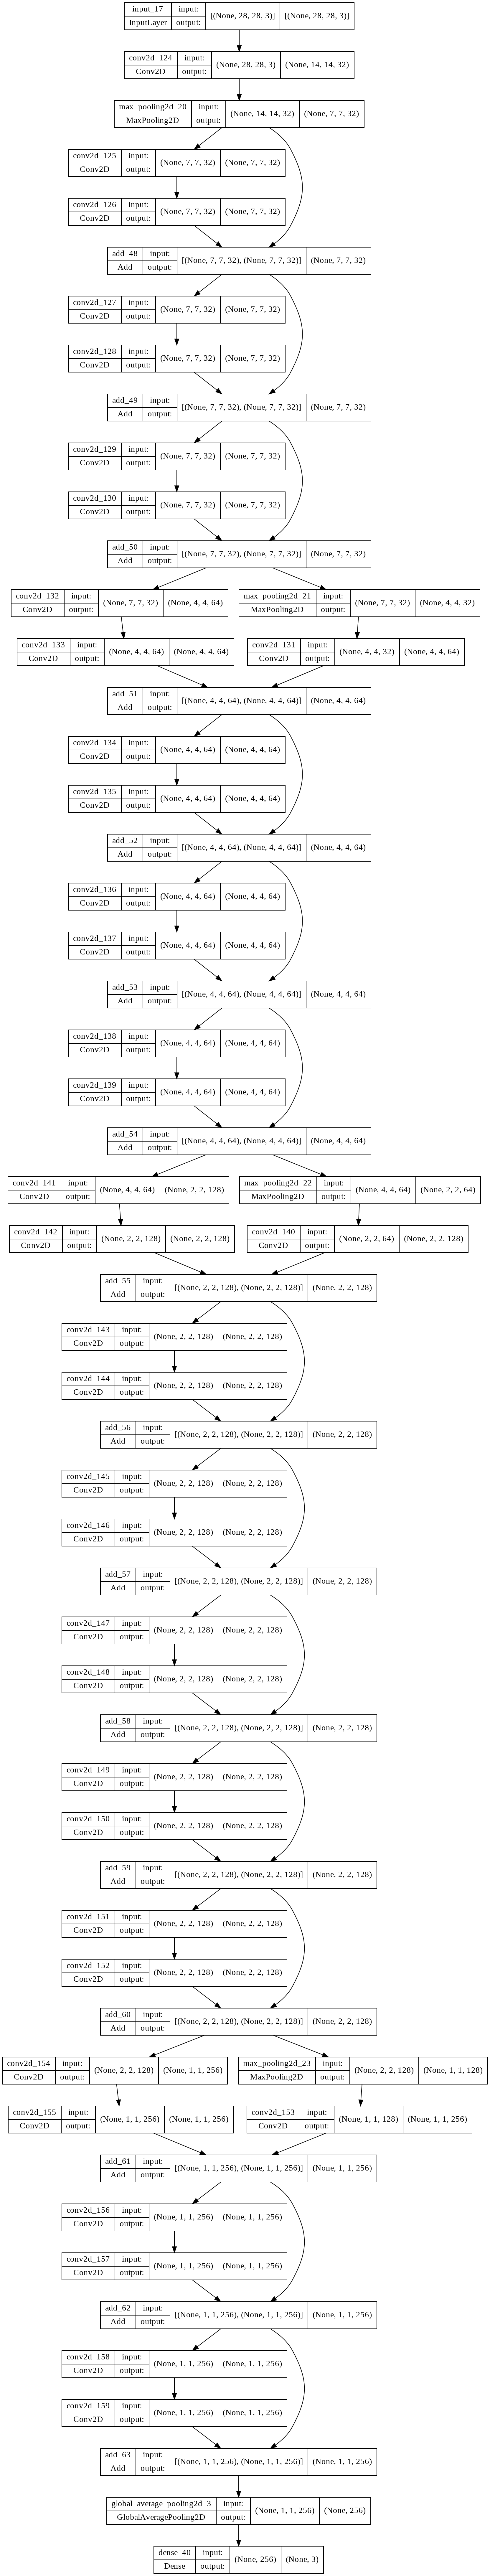

In [ ]:
MODEL_NAME="resnet34Model"
filename = os.path.join(result_path, f'{MODEL_NAME}.png')
plot_model(model_3, show_shapes=True, to_file=filename, expand_nested=True, dpi=144)

In [ ]:
model_3.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## 2) 모델 트레이닝

In [ ]:
BATCH_SIZE = 32
num_train_examples = len(x_train_norm)

import math

history_3 = model_3.fit(x_train_norm, y_train, epochs=10, batch_size=BATCH_SIZE, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE),validation_data=(x_valid_norm,y_valid))

Epoch 1/10
79/79 [==============================] - 39s 464ms/step - loss: 0.0683 - accuracy: 0.9861 - val_loss: 0.9422 - val_accuracy: 0.7930
Epoch 2/10
79/79 [==============================] - 36s 454ms/step - loss: 0.0673 - accuracy: 0.9833 - val_loss: 1.7000 - val_accuracy: 0.8575
Epoch 3/10
79/79 [==============================] - 37s 466ms/step - loss: 0.0196 - accuracy: 0.9952 - val_loss: 3.0574 - val_accuracy: 0.7177
Epoch 4/10
79/79 [==============================] - 36s 459ms/step - loss: 3.4846e-04 - accuracy: 1.0000 - val_loss: 2.1370 - val_accuracy: 0.8629
Epoch 5/10
79/79 [==============================] - 36s 455ms/step - loss: 1.1583e-06 - accuracy: 1.0000 - val_loss: 2.3004 - val_accuracy: 0.8629
Epoch 6/10
79/79 [==============================] - 36s 455ms/step - loss: 5.3534e-07 - accuracy: 1.0000 - val_loss: 2.4497 - val_accuracy: 0.8602
Epoch 7/10
79/79 [==============================] - 36s 454ms/step - loss: 2.9261e-07 - accuracy: 1.0000 - val_loss: 2.5292 - val_

## 3) 트레이닝 진행 결과

### 정확도

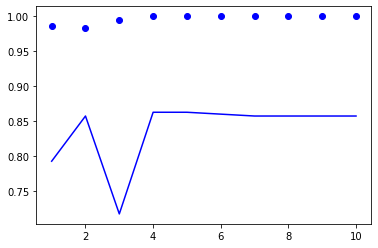

In [ ]:
history_3_accuracy = history_3.history["accuracy"]
history_3_val_accuracy = history_3.history["val_accuracy"]

epochs = range(1, len(history_3_accuracy) + 1)
plt.plot(epochs, history_3_accuracy, "bo", label="Training accuracy")
plt.plot(epochs, history_3_val_accuracy, "b", label="Validation accuracy")


### 로스

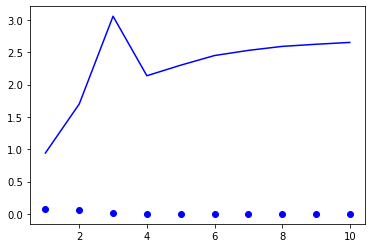

In [ ]:
history_3_loss = history_3.history["loss"]
history_3_val_loss = history_3.history["val_loss"]

epochs = range(1, len(history_3_loss) + 1)
plt.plot(epochs, history_3_loss, "bo", label="Training loss")
plt.plot(epochs, history_3_val_loss, "b", label="Validation loss")


# 5.테스트

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)
  
def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(3))
  plt.yticks([])
  thisplot = plt.bar(range(3), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
predictions_1 = model_1.predict(x_test_norm)
predictions_2 = model_2.predict(x_test_norm)
predictions_3 = model_3.predict(x_test_norm)

In [ ]:
y_test.shape

(33,)

In [ ]:
predictions_1.shape

(33, 3)

## 1) 모델1

In [ ]:
test_loss, test_acc = model_1.evaluate(x_test_norm,y_test)
print('테스트 정확도:', test_acc)

2/2 [==============================] - 0s 13ms/step - loss: 1.2309 - accuracy: 0.7576
테스트 정확도: 0.7575757503509521


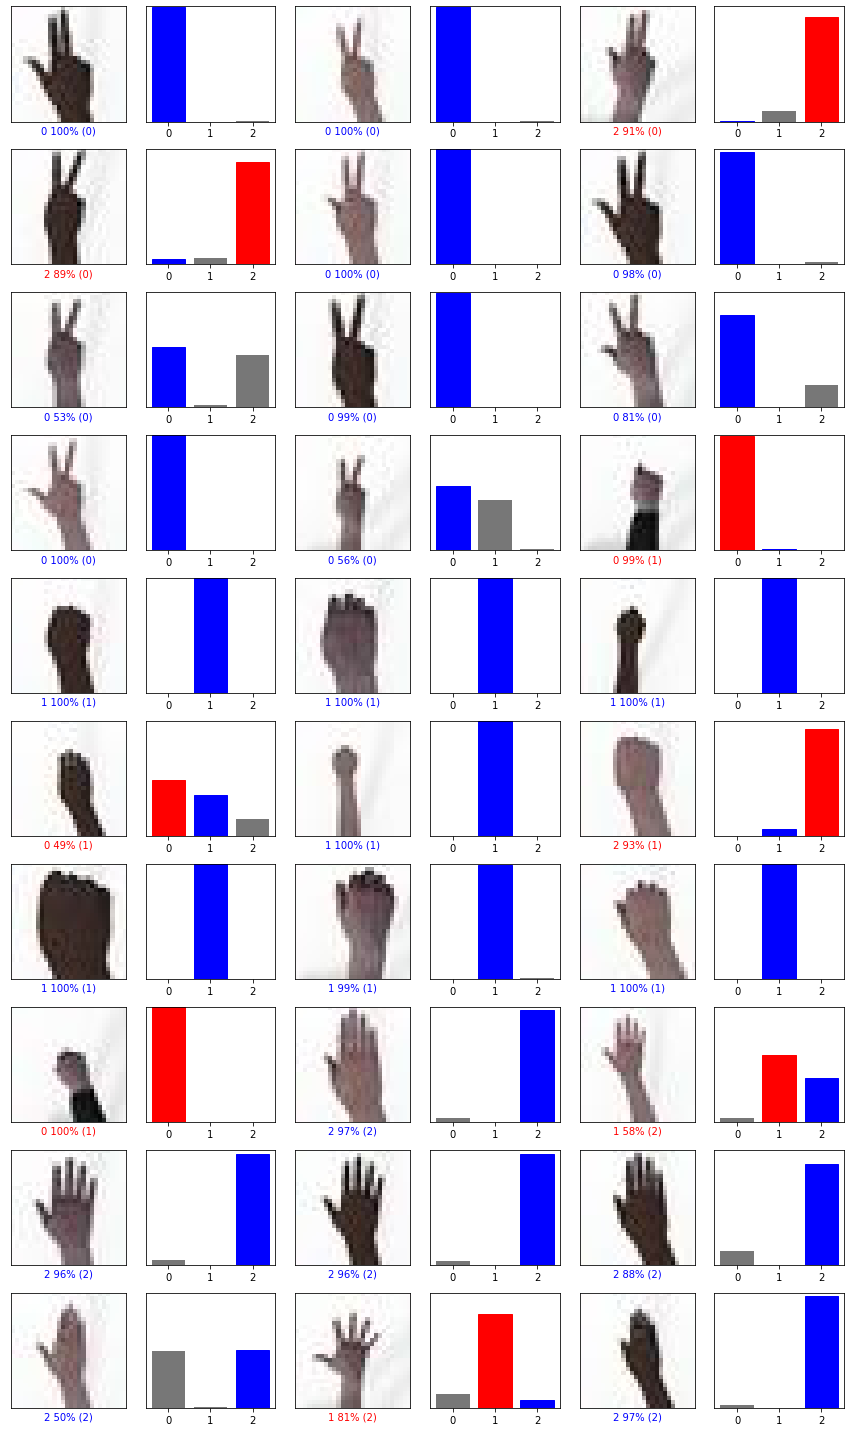

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 10
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions_1[i], y_test, x_test_norm)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions_1[i], y_test)
plt.tight_layout()
plt.show()

## 2) 모델2

In [ ]:
test_loss, test_acc = model_2.evaluate(x_test_norm,y_test)
print('테스트 정확도:', test_acc)

2/2 [==============================] - 0s 7ms/step - loss: 0.4314 - accuracy: 0.9091
테스트 정확도: 0.9090909361839294


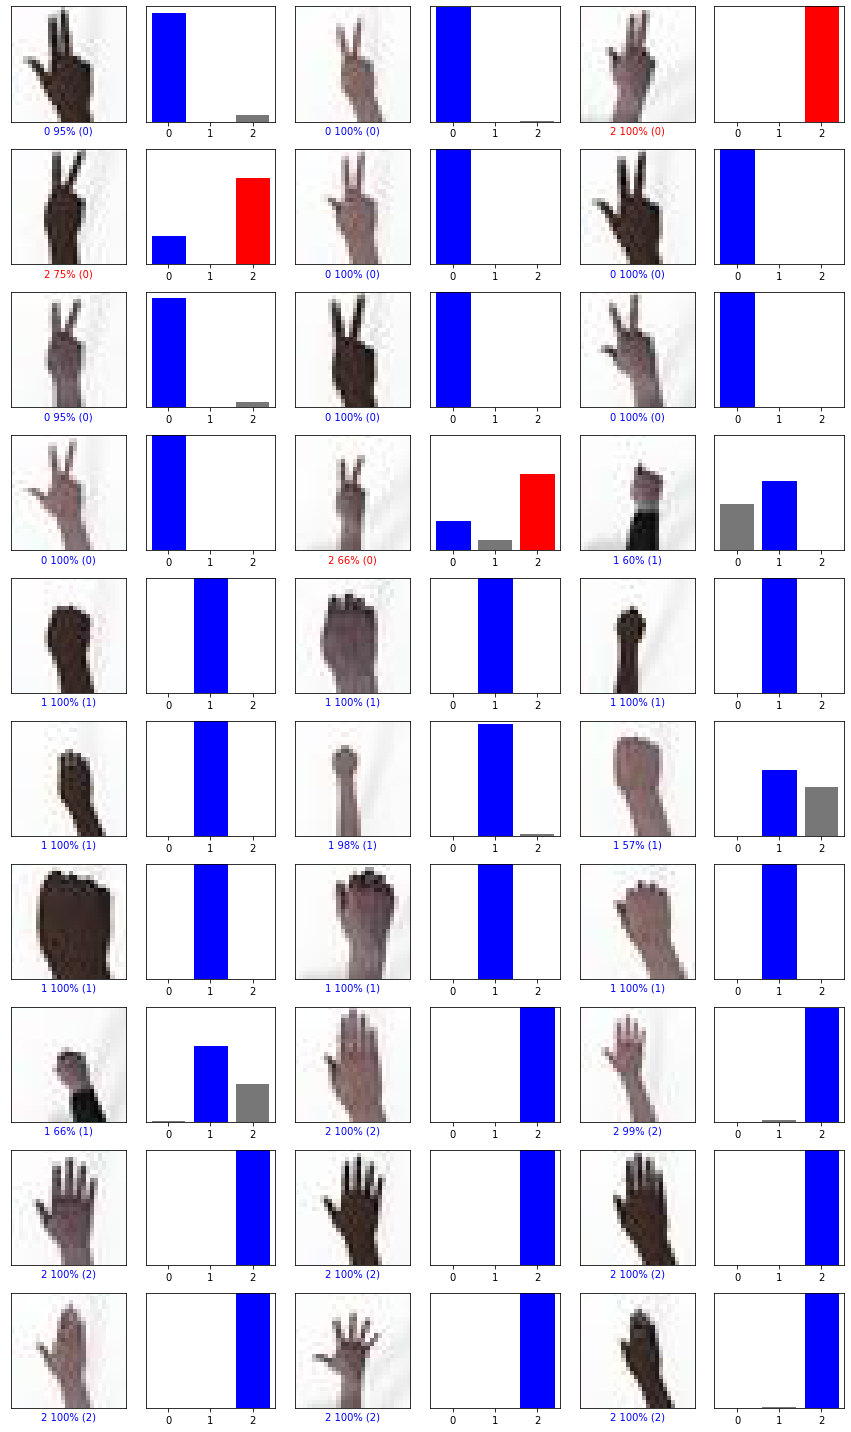

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 10
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions_2[i], y_test, x_test_norm)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions_2[i], y_test)
plt.tight_layout()
plt.show()

## 3) 모델3

In [ ]:
test_loss, test_acc = model_3.evaluate(x_test_norm,y_test)
print('테스트 정확도:', test_acc)

2/2 [==============================] - 0s 11ms/step - loss: 0.2059 - accuracy: 0.9697
테스트 정확도: 0.9696969985961914


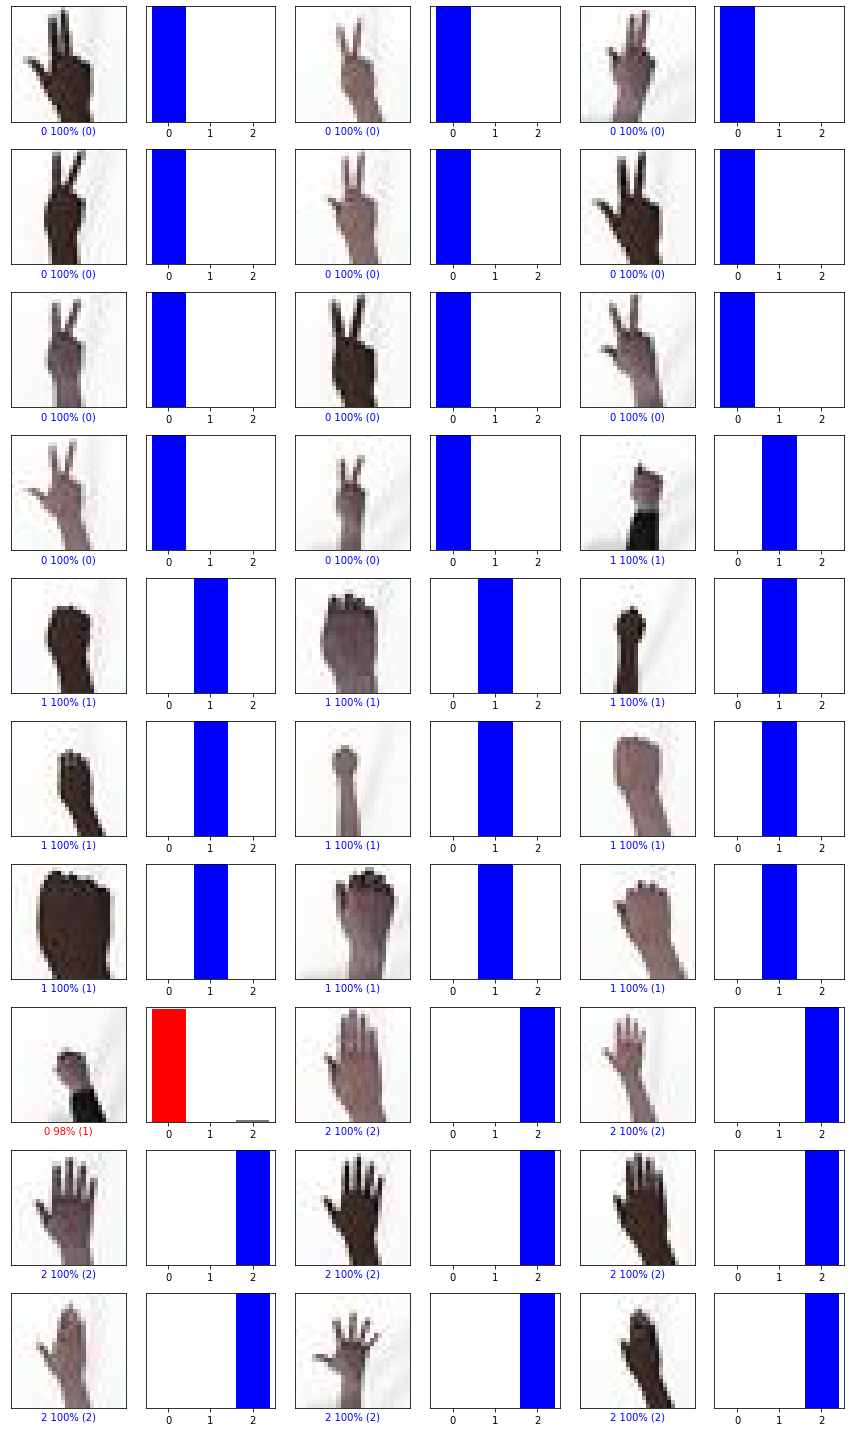

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 10
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions_3[i], y_test, x_test_norm)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions_3[i], y_test)
plt.tight_layout()
plt.show()